### Diabetic Retina Pathology 
##### Imports

In [21]:
!python --version

Python 3.7.10


In [22]:
!pip install numpy pandas sklearn

In [23]:

from __future__ import absolute_import, division, print_function
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from glob import glob


In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import InceptionV3


print("GPU Available: ", tf.config.list_physical_devices('GPU'))


GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## GPU Configuration: 
#### If Training on a GPU enabled machine, use the following imports

In [25]:
gpus = tf.config.list_physical_devices('GPU')
tf.debugging.set_log_device_placement(False)

if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
#     tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [26]:
print(os.listdir("../../resized_train_cropped/"))

['resized_train_cropped']


In [27]:
IMG_SIZE = (512, 512)
BATCH_SIZE = 48

# Data Prep

In [28]:
path = "../../resized_train_cropped/resized_train_cropped/"

In [29]:
data = "../../resized_train_cropped/resized_train_cropped/"
print('number of images in total - ',len(os.listdir(data)))

number of images in total -  35108


In [30]:
data_frame = pd.read_csv("../../trainLabels_cropped.csv") 
print('number of images in total - ',len(data_frame))
data_frame.head(10)

number of images in total -  35108


,Unnamed: 0,Unnamed: 0.1,image,level
0,0,0,10_left,0
1,1,1,10_right,0
2,2,2,13_left,0
3,3,3,13_right,0
4,4,4,15_left,1
5,5,5,15_right,2
6,6,6,16_left,4
7,7,7,16_right,4
8,8,8,17_left,0
9,9,9,17_right,1


### Intepretation of the data listed above: 
You are provided with a large set of high-resolution retina images taken under a variety of imaging conditions. A left and right field is provided for every subject. Images are labeled with a subject id as well as either left or right (e.g. 1_left.jpeg is the left eye of patient id 1).

A clinician has rated the presence of diabetic retinopathy in each image on a scale of 0 to 4, according to the following scale:

0 - No DR

1 - Mild

2 - Moderate

3 - Severe

4 - Proliferative DR

### Pre-processing and Data Visualization

In [31]:
from tensorflow.keras import utils

In [32]:
# If the patient has the retinopathy or not:
data_frame['retinopathy'] = data_frame['level'].map(lambda x: 1 if x != 0 else 0)

#Which eye is the patient having pathology: 
data_frame['right_eye'] = data_frame['image'].map(lambda x: 1 if x.split('_')[-1] == 'right' else 0)
data_frame['image_name'] = [i+".jpeg" for i in data_frame['image'].values]

# use pd.concat to join the new columns with your original dataframe
data_frame = pd.concat([data_frame,pd.get_dummies(data_frame['level'], prefix='severity:')],axis=1)

#TODO: Change the following: 
data_frame['path'] = data_frame['image'].map(lambda x: os.path.join('../../resized_train_cropped/resized_train_cropped/',
                                                         '{}.jpeg'.format(x)))
#TODO: Change the following: 
pruned_data = data_frame[['path', 'severity:_0','severity:_1','severity:_2','severity:_3','severity:_4','image_name','retinopathy']]

In [33]:
pruned_data.sample(10)

,path,severity:_0,severity:_1,severity:_2,severity:_3,severity:_4,image_name,retinopathy
29475,../../resized_train_cropped/resized_train_crop...,0,0,0,1,0,37339_right.jpeg,1
18204,../../resized_train_cropped/resized_train_crop...,1,0,0,0,0,22947_left.jpeg,0
24833,../../resized_train_cropped/resized_train_crop...,1,0,0,0,0,31428_right.jpeg,0
34212,../../resized_train_cropped/resized_train_crop...,1,0,0,0,0,43271_right.jpeg,0
22370,../../resized_train_cropped/resized_train_crop...,1,0,0,0,0,28225_left.jpeg,0
11408,../../resized_train_cropped/resized_train_crop...,1,0,0,0,0,14344_right.jpeg,0
14602,../../resized_train_cropped/resized_train_crop...,1,0,0,0,0,18319_right.jpeg,0
13240,../../resized_train_cropped/resized_train_crop...,0,0,0,1,0,16633_right.jpeg,1
5787,../../resized_train_cropped/resized_train_crop...,0,1,0,0,0,7299_right.jpeg,1
33547,../../resized_train_cropped/resized_train_crop...,1,0,0,0,0,42403_left.jpeg,0


In [34]:
np.random.choice(pruned_data['image_name'])

'7953_right.jpeg'

### Visualize a random sample from the input: 

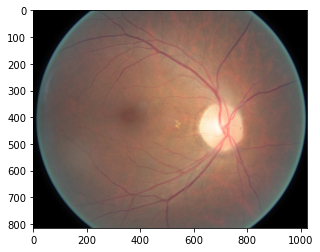

In [35]:
rand_sample = np.random.choice(pruned_data['image_name'])
temp = os.path.join(path, rand_sample)

plt.imshow(plt.imread(temp))

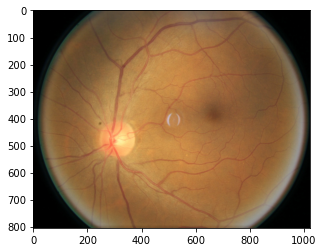

In [36]:
rand_sample = np.random.choice(pruned_data['image_name'])
temp = os.path.join(path, rand_sample)

plt.imshow(plt.imread(temp))

### Specific layout for retinopathy and left/right eyes: 

In [37]:
pruned_data[['retinopathy', 'severity:_0','severity:_1','severity:_2','severity:_3','severity:_4']].value_counts()

retinopathy  severity:_0  severity:_1  severity:_2  severity:_3  severity:_4
0            1            0            0            0            0              25802
1            0            0            1            0            0               5288
                          1            0            0            0               2438
                          0            0            1            0                872
                                                    0            1                708
dtype: int64

# Batch Generation

In [38]:
# train1, val = train_test_split(index, test_size=0.2)
# train, test = train_test_split(train1, test_size=0.25)

#80/20/20 split

train1_ids, valid_ids = train_test_split(pruned_data,test_size = 0.2)
train_and_test = pruned_data[pruned_data.isin(train1_ids)]

train_ids, test_ids = train_test_split(train_and_test,test_size = 0.25)

train_set =train_ids.dropna()

valid_set = valid_ids.dropna()
test_set = test_ids.dropna()

In [39]:
print(train_set.shape, test_set.shape, valid_set.shape)
print(type(train_set))

(21109, 8) (6977, 8) (7022, 8)
<class 'pandas.core.frame.DataFrame'>


In [40]:
# train_x = train_set.drop('level', axis=1)
# train_y = train_set['level']


## Image Data Generation: 

In [41]:
from tensorflow.keras.applications import VGG16,InceptionResNetV2,InceptionV3 as pretrained_model
import random
from PIL import Image

In [42]:
def calc_mean_and_std(img_directory_list):
        """ Calculate mean and standard deviation of a sample of the
        training dataset for standardization.

        Arguments: none

        Returns: none
        """
        PREPROCESS_SAMPLE_SIZE = 24
        IMG_LENGTH_HEIGHT = 512
         
        # Get list of all images in training directory
        file_list = np.copy(img_directory_list)


        # Shuffle filepaths
        random.shuffle(file_list)

        # Take sample of file paths
        file_list = file_list[:PREPROCESS_SAMPLE_SIZE]

        # Allocate space in memory for images
        data_sample = np.zeros(
            (PREPROCESS_SAMPLE_SIZE,IMG_LENGTH_HEIGHT, IMG_LENGTH_HEIGHT, 3))

        # Import images
        for i, file_path in enumerate(file_list):
            img = Image.open(file_path)
            img = img.resize((IMG_LENGTH_HEIGHT, IMG_LENGTH_HEIGHT))
            img = np.array(img, dtype=np.float32)
#             img /= 255.

            # Grayscale -> RGB
            if len(img.shape) == 2:
                img = np.stack([img, img, img], axis=-1)

            data_sample[i] = img

        # TODO: Calculate the pixel-wise mean and standard deviation
        #       of the images in data_sample and store them in
        #       self.mean and self.std respectively.
        # ==========================================================

        mean = np.mean(data_sample, axis=(0, 1, 2))
        std = np.std(data_sample, axis=(0, 1, 2))

        # ==========================================================

        print("Dataset mean: [{0:.4f}, {1:.4f}, {2:.4f}]".format(
            mean[0], mean[1], mean[2]))

        print("Dataset std: [{0:.4f}, {1:.4f}, {2:.4f}]".format(
            std[0], std[1], std[2]))
        
        return mean, std

In [43]:
train_set_mean, train_set_std = calc_mean_and_std(train_set['path'])

Dataset mean: [112.6131, 83.6610, 65.1998]
Dataset std: [75.6498, 56.1141, 46.7200]


In [44]:
def train_img_preprocess_fn(img):
    img = tf.keras.applications.vgg16.preprocess_input(img)
#     img = tf.keras.applications.inception_v3.preprocess_input(img)
#     img = tf.keras.applications.inception_resnet_v2.preprocess_input(img)
#     img = img / 255
#     print(img)
    for layer in range(img.shape[2]):
            img[:,:,layer] = (img[:,:,layer] - train_set_mean[layer]) / train_set_std[layer]

    return img

In [45]:
def get_processed_data(data_frame):
  
    data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
#                     featurewise_center=True,
#                     featurewise_std_normalization=True,
#                     zca_whitening = True, 
                    rotation_range=20,
                    width_shift_range=5,
                    height_shift_range=5,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    vertical_flip = True, 
#                     preprocessing_function=train_img_preprocess_fn
    )
    
    # Form image data generator from directory structure
#     data_gen = data_gen.flow_from_directory(
#         path,
#         target_size=IMG_SIZE,
#         class_mode='sparse',
#         batch_size=BATCH_SIZE,
#         shuffle=True,
#         classes=classes_for_flow)
    data_gen = data_gen.flow_from_dataframe(
        data_frame,
        directory=None,
        x_col="path",
        y_col=['severity:_0','severity:_1','severity:_2','severity:_3','severity:_4'],
        weight_col=None,
        target_size=IMG_SIZE,
        color_mode="rgb",
        classes=None,
        class_mode="raw",
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=None,
        save_to_dir=None,
        save_prefix="",
        save_format="png",
        subset=None,
        interpolation="nearest",
        validate_filenames=False,
    )
    
    return data_gen

In [46]:
def get_unprocessed_data(data_frame):


    data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
#                     featurewise_center=True,
#                     featurewise_std_normalization=True,
#                     rotation_range=20,
#                     width_shift_range=0.2,
#                     height_shift_range=0.2,
#                     shear_range=0.2,
#                     zoom_range=0.2,
                    horizontal_flip=True,
                    vertical_flip = True, 
#                     preprocessing_function=img_preprocess_fn
    )
    
    # Form image data generator from directory structure
#     data_gen = data_gen.flow_from_directory(
#         path,
#         target_size=IMG_SIZE,
#         class_mode='sparse',
#         batch_size=BATCH_SIZE,
#         shuffle=True,
#         classes=classes_for_flow)
    data_gen = data_gen.flow_from_dataframe(
        data_frame,
        directory=None,
        x_col="path",
        y_col=['severity:_0','severity:_1','severity:_2','severity:_3','severity:_4'],
        weight_col=None,
        target_size=IMG_SIZE,
        color_mode="rgb",
        classes=None,
        class_mode="raw",
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=None,
        save_to_dir=None,
        save_prefix="",
        save_format="png",
        subset=None,
        interpolation="nearest",
        validate_filenames=False,
    )
    
    return data_gen

#### Training Set:

In [47]:
gen_train_set = get_processed_data(train_set)
print(gen_train_set)

Found 21109 non-validated image filenames.


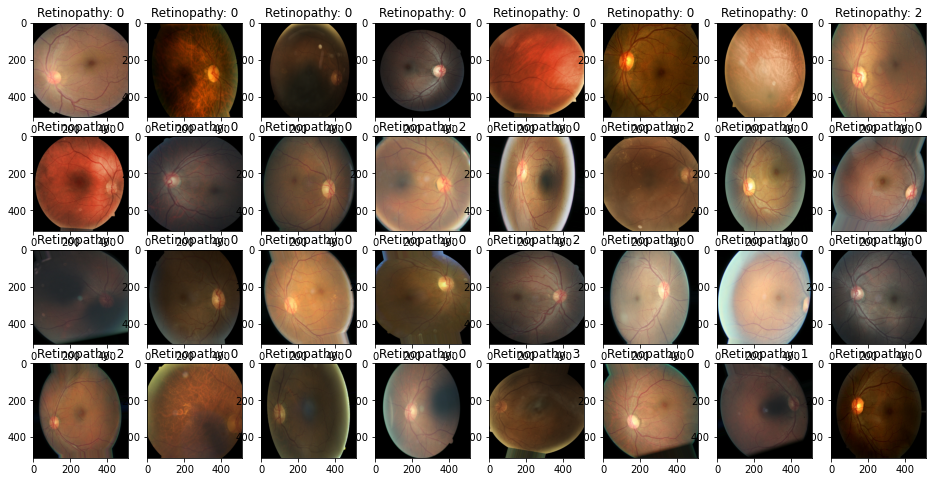

In [48]:
retina_data, retina_sev = next(gen_train_set)
    
figure, plot_axs = plt.subplots(4, 8, figsize = (16, 8))


for (data, sev, subplt) in zip(retina_data, retina_sev, plot_axs.flatten()):
    clipped = np.clip(data, 0, 255).astype(np.uint8)
    
    subplt.imshow(clipped)
    subplt.set_title('Retinopathy: {}'.format(np.argmax(sev, axis=0)))

#### Validation Set:

In [49]:
gen_valid_set = get_unprocessed_data(valid_set)
print(gen_valid_set)

Found 7022 non-validated image filenames.


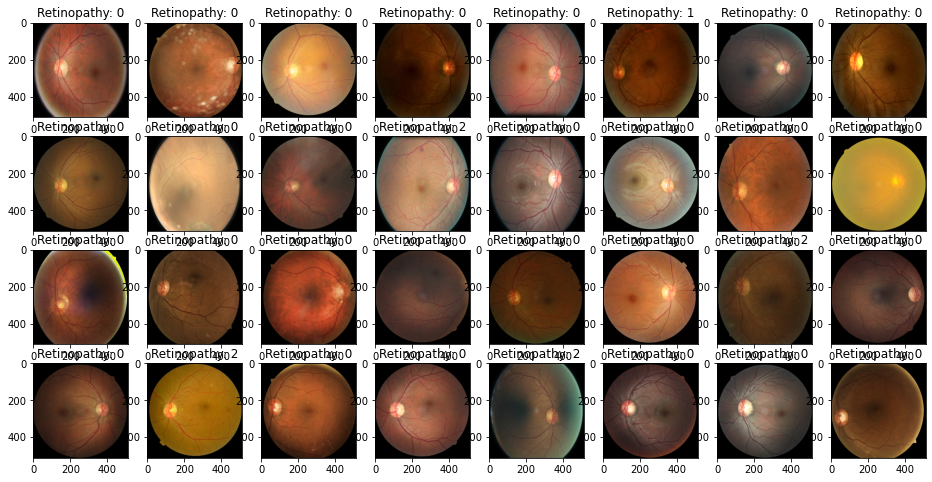

In [50]:
retina_data, retina_sev = next(gen_valid_set)
    
figure, plot_axs = plt.subplots(4, 8, figsize = (16, 8))


for (data, sev, subplt) in zip(retina_data, retina_sev, plot_axs.flatten()):
    clipped = np.clip(data, 0, 255).astype(np.uint8)
    
    subplt.imshow(clipped)
    subplt.set_title('Retinopathy: {}'.format(np.argmax(sev, axis=0)))

#### Test Set:

In [51]:
gen_test_set = get_unprocessed_data(test_set)
print(gen_test_set)

Found 6977 non-validated image filenames.


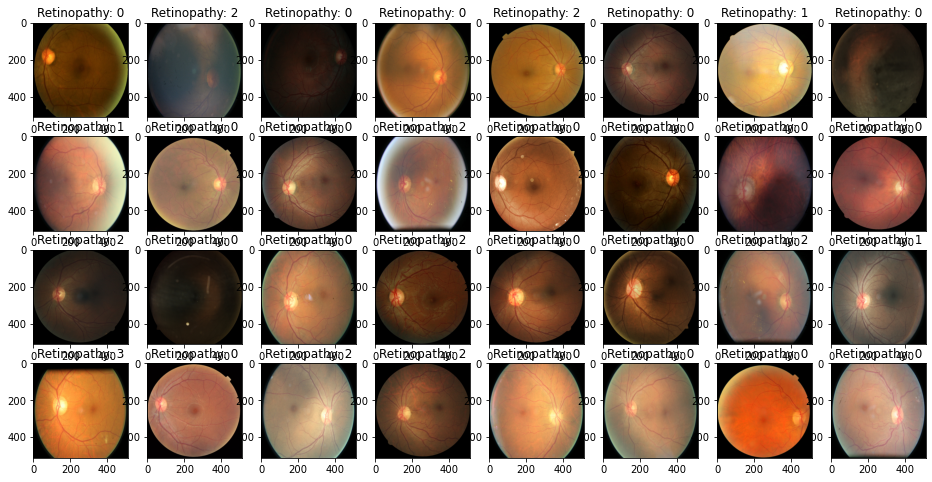

In [52]:
retina_data, retina_sev = next(gen_valid_set)
    
figure, plot_axs = plt.subplots(4, 8, figsize = (16, 8))


for (data, sev, subplt) in zip(retina_data, retina_sev, plot_axs.flatten()):
    clipped = np.clip(data, 0, 255).astype(np.uint8)
    
    subplt.imshow(clipped)
    subplt.set_title('Retinopathy: {}'.format(np.argmax(sev, axis=0)))

In [53]:
#type(t_x)

## Training:

In [54]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout,LocallyConnected2D, MaxPool2D, Flatten, Input, Conv2D, multiply, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import top_k_categorical_accuracy

In [55]:
from tensorflow.keras.applications.inception_v3 import InceptionV3 as pretrained_model

In [57]:
input_layer = Input(retina_data.shape[1:])
base_pretrained_model = pretrained_model(input_shape =  retina_data.shape[1:], include_top = False, weights = 'imagenet')

base_pretrained_model.trainable = False
base_pretrained_model.summary()
base_pretrained_model

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 255, 255, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 255, 255, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 255, 255, 32) 0           batch_normalization[0][0]        
______________________

# Build Model

In [58]:
after_imagenet = base_pretrained_model(input_layer)

In [59]:
batch_normalization_layer = BatchNormalization()(after_imagenet)

In [60]:
print(batch_normalization_layer)

KerasTensor(type_spec=TensorSpec(shape=(None, 14, 14, 2048), dtype=tf.float32, name=None), name='batch_normalization_94/FusedBatchNormV3:0', description="created by layer 'batch_normalization_94'")


In [62]:
out_custom_head = Conv2D(512, 3, 1, padding="same", activation="relu", name="trainable1_head_1",)(batch_normalization_layer)
out_custom_head = Conv2D(256, 3, 1, padding="same", activation="relu", name="trainable1_head_2")(out_custom_head)
out_custom_head = Conv2D(128, 3, 1, padding="same", activation="relu", name="trainable1_head_3")(out_custom_head)
                 

In [63]:
out_custom_head = Conv2D(64, 3, 1, padding="same", activation="relu", name="trainable2_head_1")(out_custom_head)
out_custom_head = GlobalAveragePooling2D()(out_custom_head)

out_custom_head=Dense(128,activation='softmax')(out_custom_head)
out_custom_head=Dense(5,activation='softmax')(out_custom_head)

In [68]:
def highest_accuracy(input_data, input_prediction):
    return top_k_categorical_accuracy(input_data, input_prediction, k=1)

In [69]:
retina_model = tf.keras.models.Model(inputs = [input_layer], outputs = [out_custom_head])
retina_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy', highest_accuracy])

retina_model.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 14, 14, 2048)      21802784  
_________________________________________________________________
batch_normalization_94 (Batc (None, 14, 14, 2048)      8192      
_________________________________________________________________
trainable1_head_1 (Conv2D)   (None, 14, 14, 512)       9437696   
_________________________________________________________________
trainable1_head_2 (Conv2D)   (None, 14, 14, 256)       1179904   
_________________________________________________________________
trainable1_head_3 (Conv2D)   (None, 14, 14, 128)       295040    
_________________________________________________________________
trainable2_head_1 (Conv2D)   (None, 14, 14, 64)        7379

#### Output after ImageNet Pretrained

# Train Model

In [70]:
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard
import os

import sys
import argparse
import re
from datetime import datetime

In [71]:
time_now = datetime.now()
timestamp = time_now.strftime("%m%d%y-%H%M%S")
checkpoint_path = "checkpoints" + os.sep + "your_model" + os.sep + timestamp + os.sep
logs_path = "logs" + os.sep + "your_model" + os.sep + timestamp + os.sep
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='auto', save_weights_only = True,save_freq='epoch')


In [72]:
callbacks_list = [checkpoint]


In [73]:
model_train = retina_model.fit(gen_train_set, 
                           steps_per_epoch = np.array(train_set.shape[0]//BATCH_SIZE),
                           validation_data = gen_valid_set, 
                           validation_steps = valid_set.shape[0]//BATCH_SIZE,
                              epochs = 10, 
                              callbacks = callbacks_list)

Epoch 1/4
 13/439 [..............................] - ETA: 20:36 - loss: 1.5275 - categorical_accuracy: 0.6932 - highest_accuracy: 0.6932

KeyboardInterrupt: 

In [ ]:
!rm -rf ~/.keras # clean up before starting training
!rm -rf ~/.local/share/Trash/*

In [ ]:
!sudo chown 1000:1001 /opt/conda/pkgs/cache/18414ddb.json

In [ ]:
# load the best version of the model
retina_model.load_weights(weight_path)
retina_model.save('full_retina_model.h5')

### Run this if it's first time running 

In [ ]:
retina_model.save('full_retina_model.h5')

### Run this if loading from the machine 

In [ ]:
retina_model.load('full_model_inceptionv3_0421_2021.h5')

In [ ]:
#plt.plot(model_train.history['acc'])
#plt.plot(model_train.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'var'], loc='best')
plt.show()

plt.plot(model_train.history['loss'])
plt.plot(model_train.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'var'], loc='best')
plt.show()

# Test Some Images

In [ ]:
from PIL import Image
im = Image.open("../input/diabetic-retinopathy-resized/resized_train/resized_train/" + val.iloc[0].image_name)
im = np.array(im.resize((224, )*2, resample=Image.LANCZOS))
im.shape

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(im)

In [ ]:
import cv2

testimage = cv2.resize(im, (224,224))
testimage = cv2.addWeighted(image,4,cv2.GaussianBlur(image,(0,0),10) ,-4 ,128) 

print("predicted:", np.argmax(model.predict(testimage.reshape(1, *im.shape))[0]))
print("actual:", val.iloc[0].level)